# Construct Your Own CKConv Layer

In this notebook, we provide a simplified construction of a CKConv layer, proposed in our work [CKConv: Continuous Kernel Convolution for Sequential Data](https://arxiv.org/abs/2102.02611). The code provided here is a simplified version of the main code. For baseline comparisons please refer to the main code.

In particular, we will:
* Implement a `CKConv` layer.
* Instantiate a CKConv layer and analyze its properties.

Let's go! First, we import some packages:

In [1]:
# Append .. to path
import os,sys
ckconv_source =  os.path.join(os.getcwd(), '..')
if ckconv_source not in sys.path:
    sys.path.append(ckconv_source)
    
import numpy as np
import torch
from torch.nn.utils import weight_norm

import ckconv
import ckconv.nn.functional as ckconv_f

from matplotlib import pyplot as plt

Recall that a CKConv is simply a convolutional network in which the convolutional kernel is parameterized by an MLP. 

We first code up the `KernelNet`, which will provide us with the convolutional kernel:

In [2]:
# This is a simplified version of the code. 
# A complete version can be found in `ckconv/nn/ckconv.py`.

class KernelNet(torch.nn.Module):
    def __init__(
        self,
        out_channels: int,
        hidden_channels: int,
        bias: bool,
        omega_0: float,
    ):
        super().__init__()
        '''
        KernelNets are implemented as a 3-layer MLP with sine nonlinearities. 
        
        Args:
        
         - out_channels: Output channels of KernelNet. For a Conv1D with Nin input channels and Nout output 
                         channels, out_channels is Nin * Nout. 
         - hidden_channels: The hidden dimension of KernelNet.
         - bias: If the layers will use bias.
         - omega_0: A prior on the variation of the kernel we want to model. More information on w_0 can be 
                    found in Sec. 4.3 of the paper, and the SIREN paper of Sitzman et. al. (Sec. 3.2., Appx. 1.5) 
                    https://arxiv.org/abs/2006.09661.
        
        '''
        
        ActivationFunction = ckconv.nn.Sine
        Linear = ckconv.nn.Linear1d  # Implements a Linear layer in terms of 1x1 Convolutions.
        Multiply = ckconv.nn.misc.Multiply  # Multiplies the input by a constant 
        
        # The input of the network is a vector of relative positions. That is, input_dimension = 1.
        self.kernel_net = torch.nn.Sequential(
            # 1st layer
            weight_norm(Linear(1, hidden_channels, bias=bias)),
            Multiply(omega_0),
            ActivationFunction(),
            # 2nd Layer
            weight_norm(Linear(hidden_channels, hidden_channels, bias=bias)),
            Multiply(omega_0),
            ActivationFunction(),
            # 3rd Layer
            weight_norm(Linear(hidden_channels, out_channels, bias=bias)),
        )

        # initialize the kernel function
        self.initialize(
            mean=0.0,
            variance=0.01,
            bias_value=0.0,
            omega_0=omega_0,
        )

    def initialize(self, mean, variance, bias_value, omega_0):

        # Initialization of SIRENs (Please refer to https://arxiv.org/abs/2006.09661 for details).
        net_layer = 1
        for (i, m) in enumerate(self.modules()):
            if (
                isinstance(m, torch.nn.Conv1d)
                or isinstance(m, torch.nn.Conv2d)
                or isinstance(m, torch.nn.Linear)
            ):
                if net_layer == 1:
                    m.weight.data.uniform_(-1, 1)  # Normally (-1, 1) / in_dim but we only use 1D inputs.
                    net_layer += 1
                else:
                    m.weight.data.uniform_(
                        -np.sqrt(6.0 / m.weight.shape[1]) / omega_0,
                        # the in_size is dim 2 in the weights of Linear and Conv layers
                        np.sqrt(6.0 / m.weight.shape[1]) / omega_0,
                    )
                    
                # Important! Bias is not defined in original SIREN implementation
                if m.bias is not None:
                        m.bias.data.uniform_(-1.0, 1.0)
                        
                        
    def forward(self, x):
        return self.kernel_net(x)

With `KernelNet` finished, we can now construct our `CKConv` layer. The main difference with a `torch.nn.1DConv` layer is the fact that we now use `KernelNet` as our convolutional kernel as opposed to a weight matrix.

In [3]:
class CKConv(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        bias: bool,
        omega_0: float,
    ):
        super().__init__()
        
        # Conv. Kernel is now parameterized by a KernelNet
        self.Kernel = KernelNet(
            out_channels * in_channels,
            hidden_channels,
            bias,
            omega_0,
        )

        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
            self.bias.data.fill_(value=0.0)
        else:
            self.bias = None

        self.rel_positions = None
        self.register_buffer("conv_kernel", torch.zeros(in_channels), persistent=False)
        
        
    def forward(self, x):
        '''
        The forward pass consists of 3 main steps:
        
        1. The first time the CKConv sees an input, it will check its dimensionality. Based on that,
           we create a vector of (normalized) relative positions of equal length.
           
        2. We now pass the vector of relative positions trhough self.Kernel. This will create the 
           convolutional kernel of the layer on the fly. 
           
        3. We then compute the convolution. As the convolutional kernel is often large, we use a 
           Fourier Convolution to reduce computation complexity.
        
        '''
        
        # Construct kernel (Step 1)
        x_shape = x.shape
        rel_pos = self.handle_rel_positions(x)
        
        # Pass relative prositions through self.Kernel (Step 2)
        conv_kernel = self.Kernel(rel_pos).view(-1, x_shape[1], *x_shape[2:])
        self.conv_kernel = conv_kernel
        
        # Compute the convolution
        return ckconv_f.causal_fftconv(x, conv_kernel, self.bias, double_precision=False)
    
    
    def handle_rel_positions(self, x):
        if (self.rel_positions is None):
            self.rel_positions = (torch.linspace(-1.0, 1.0, x.shape[-1]).unsqueeze(0).unsqueeze(0))  
            # -> Of form (batch_size=1, in_channels=1, x_dimension=x.shape[-1])
        return self.rel_positions

Voila! We can now create `CKConv` layers:

In [4]:
in_channels = 1
out_channels = 10
hidden_channels = 32
bias = True
omega_0 = 30.0

ckconv1 = CKConv(in_channels, out_channels, hidden_channels, bias, omega_0)

Now, we can, for instance, perform a convolution on an input of size 1000. The layer will automatically handle this and provide a kernel of matching size:

The size of the Convolutional Kernel is: torch.Size([10, 1, 1000])


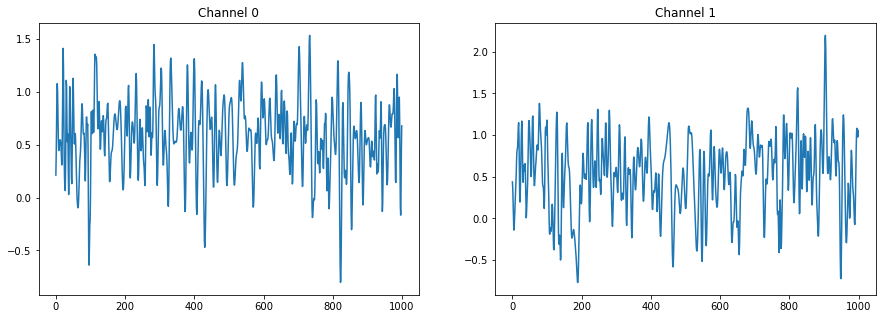

The number of parameters of the conv. layer is: 1534


In [5]:
# ------------------------------
# Parameter counter
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# -----------------------------


# Input:
length = 1000
input_channels = 1
batch_size = 1

input_signal = torch.rand([batch_size, input_channels, length])
output = ckconv1(input_signal)

print('The size of the Convolutional Kernel is: {}'.format(ckconv1.conv_kernel.shape))

# Let's plot some channels of our convolutional kernel
fig, axs = plt.subplots(1, 2,figsize=(15,5))
for i in range(2):
    axs[i].set_title('Channel {}'.format(i))
    axs[i].plot(ckconv1.conv_kernel.view(out_channels, length)[i].detach().numpy())
plt.show()

print('The number of parameters of the conv. layer is: {}'.format(num_params(ckconv1)))

Interestingly, we see that our filters are already quite expressive at initialization. Note that a conventional `1dConv` would require **[10 * 1 * 1000] = 10000** weights to create a similar conv. kernel.

### Data at different sampling rates 

Interestingly, this continuous kernel parameterization allows us to handle data sampled at different sampling rates easily.

**Problem:** Imagine that we have the kernels shown above, which produce a response for an input of length 1000 resulting from sampling at a particular sampling rate. Now, imagine that the same input has been re-sampled and now the input is of length 500 and 2000. What can we do? Can we still use our original layer? 

If we use a `1dConv` or a recurrent layer, this would be problematic as the spatial dimensionality of the kernel / the input, will not match the one the model has learned. 

**Solution:** However, we can still use a `CKConv`. In order to produce a similar response to the resampled input, we can simply sample the convolutional kernel at the corresponding sampling rate. This is done by sampling the relative positions fed to `KernelNet` either finer or coarser. 

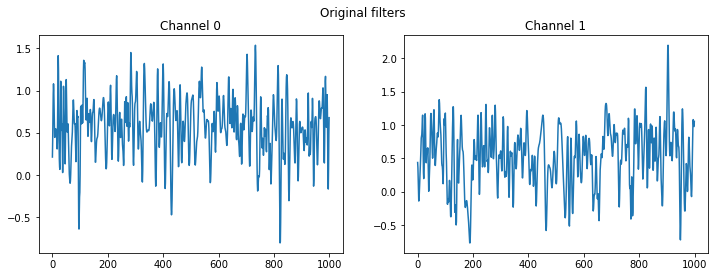

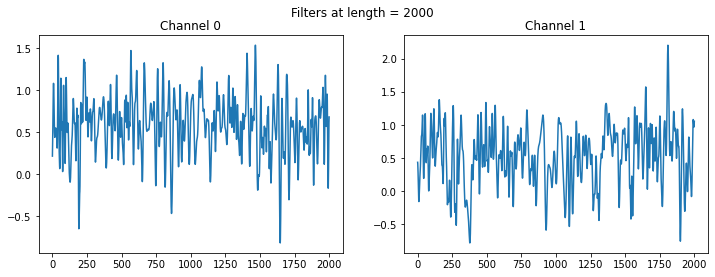

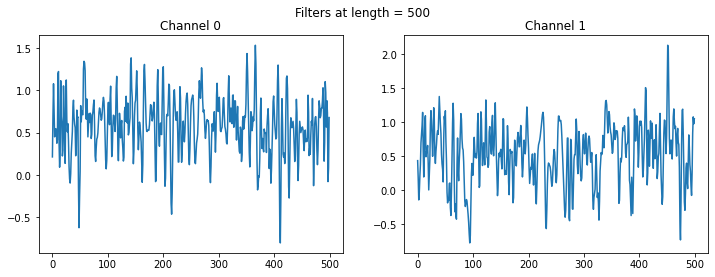

In [6]:
# Let's plot some channels of our convolutional kernel
figsize = (12, 4)

fig, axs = plt.subplots(1, 2,figsize=figsize)
fig.suptitle('Original filters')
for i in range(2):
    axs[i].set_title('Channel {}'.format(i))
    axs[i].plot(ckconv1.conv_kernel.view(out_channels, length)[i].detach().numpy())
plt.show()


#### Case input length = 2000

# Input:
length = 2000
input_channels = 1
batch_size = 1

input_signal = torch.rand([batch_size, input_channels, length])
ckconv1.rel_positions = None
output = ckconv1(input_signal)

fig, axs = plt.subplots(1, 2,figsize=figsize)
fig.suptitle('Filters at length = {}'.format(length))
for i in range(2):
    axs[i].set_title('Channel {}'.format(i))
    axs[i].plot(ckconv1.conv_kernel.view(out_channels, length)[i].detach().numpy())
plt.show()

#### Case input length = 500

# Input:
length = 500
input_channels = 1
batch_size = 1

input_signal = torch.rand([batch_size, input_channels, length])
ckconv1.rel_positions = None
output = ckconv1(input_signal)

fig, axs = plt.subplots(1, 2,figsize=figsize)
fig.suptitle('Filters at length = {}'.format(length))
for i in range(2):
    axs[i].set_title('Channel {}'.format(i))
    axs[i].plot(ckconv1.conv_kernel.view(out_channels, length)[i].detach().numpy())
plt.show()


As we can see, the filters are very well aligned. In fact, the responses of the input at different rates will be exactly equal up to a renormalization factor (see Sec. 4.1 for details).